# Spectral analysis
- Load data
- Preprocess
    - Resample down to 3kHz
    - Notch line noise and harmonics
    - Reference CAR
    - Compute wavelet transform
    - Resample down to 400Hz
- Plot spectrogram for one channel

In [1]:
from process_nwb import resample, linenoise_notch, common_referencing, wavelet_transform
from nsds_lab_to_nwb.tools.tdt.tdt_reader import TDTReader
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from laminar_uecog_viz import spectral

In [2]:
# Plotting parameters
mpl.rcParams['figure.facecolor'] = '1'

## User defined parameters

In [3]:
data_path = '/home/jhermiz/data/aer/RVG16/RVG16_B01/' #path where TDT data lives
data_dump_path = os.path.join(data_path, 'preprocessed') #path to dump preprocessed data
plot_dump_path = os.path.join(data_path, 'plot') #path to save plots

fs = 3200 #intermediate (before wavelet transform) sample rate
fs_final = 400 #final sample rate (after wavelet transform)
num_ch = 1 #change to -1 for all channels

## Load data

In [4]:
rec = TDTReader(data_path)
data, params = rec.get_data(stream='Wave')
print(data.shape, params)

read from t=0s to t=77.86s
(950272, 128) {'sample_rate': 12207.03125, 'channel_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], 'start_time': '11:53:14', 'num_channels': 128, 'num_samples': 950272}


In [5]:
# Timestamps where stimulus occurs (correct for 0.25s offset)
events = rec.get_events()
events += events + 0.25
print(f'Number of events: {str(len(events))}')

Number of events: 60


## Preprocess

In [6]:
chs = range(data.shape[1])
num_frame = data.shape[0]

if num_ch < 0:
    num_ch = len(chs)

data_proc = resample.resample(data, fs, params['sample_rate'])
data_proc = linenoise_notch.apply_linenoise_notch(data_proc, fs)
data_proc = common_referencing.subtract_CAR(data_proc)
t = np.arange(0, num_frame)/fs

data_proc_file = os.path.join(data_dump_path, 'data_proc.npy')
np.save(data_proc_file, data_proc)
time_file = os.path.join(data_dump_path, 'time.npy')
np.save(time_file, t)  

In [7]:
# Calculate wavelet transform
for ch in chs[:num_ch]:
    t1 = time.time()
    print('Starting wavelet transform')
    W, _, f, _ = wavelet_transform.wavelet_transform(data_proc[:, ch].reshape((-1, 1)), 
                                                     fs, filters='rat', hg_only=False)
    W = np.float32(abs(W))
    W = resample.resample(W, fs_final, fs)
    t2 = time.time()
    wavelet_file = os.path.join(data_dump_path, f'wavelet_coefs_ch{str(ch)}.npy')
    np.save(wavelet_file, W)
    print(f'Wavelet compute time: {str(np.round(t2-t1, 2))}s')

print('Done preprocessing')

Starting wavelet transform
Wavelet compute time: 2.08s
Done preprocessing


In [8]:
W = np.squeeze(W, axis=1)

## Plot spectrogram for a 0.5 sec window

Text(0, 0.5, 'Frequency (Hz)')

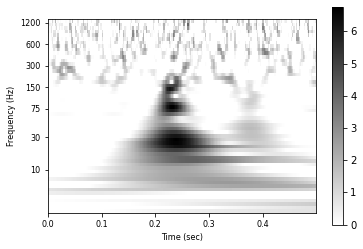

In [9]:
tbeg = int(fs_final*14.35)
tend = tbeg + int(fs_final*0.5)
Wsnip = W[tbeg:tend, :]
mean = np.mean(W, axis=0)
sigma = np.std(W, axis=0)
Wsnip_norm = (Wsnip - mean)/sigma
t = np.arange(0, tend-tbeg)/fs_final
fig, ax = spectral.plot_spectrogram(Wsnip_norm, f, t, colorbar=True)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Frequency (Hz)')